In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [3]:
# Загрузили DF
carsDF = pd.read_csv("C:/Users/kazan/Desktop/carsdataset.csv")
carsDF = carsDF[['maker',
          'model',
          'mileage',
          'manufacture_year',
          'engine_displacement',
          'engine_power',
          'price_eur',
         'fuel_type']]

carsDF.dropna(inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7,8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Исправили данные (выкинули лишнее)
carsDF['mileage'] = carsDF['mileage'].apply(lambda x: x*1.60934)
carsDF['price_rur'] = carsDF['price_eur'].apply(lambda x: x*69.3)
del carsDF['price_eur']
carsDF = carsDF.loc[carsDF['maker'] == "bmw"]

In [5]:
# Делим признаки на категориальные и числовые
trainDecimal = carsDF[['mileage','price_rur','engine_power','manufacture_year','engine_displacement']]
trainCategorical = carsDF[['manufacture_year','maker','model','engine_displacement','fuel_type']].astype(str)

trainCategoricalTransformed = MultiColumnLabelEncoder(columns = ['manufacture_year',
                                               'maker',
                                               'model',
                                               'engine_displacement',
                                               'fuel_type']).fit_transform(trainCategorical)

In [6]:
# Нормализация
scaler = StandardScaler()
scaler.fit(trainDecimal)
trainDecimalTransformed = scaler.transform(trainDecimal)

ohe = OneHotEncoder(sparse = False)
ohe.fit(trainCategoricalTransformed)
trainTransformed = ohe.transform(trainCategoricalTransformed)

#total =trainDecimalTransformed
total = np.hstack((trainTransformed,trainDecimalTransformed))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
# Обучаем и предсказываем
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(total)

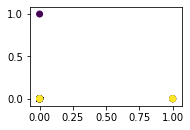

In [11]:
#Рисуем график как разбило по кластерам признак 0-го столбца по отношению ко N-му
plt.subplot(221)
plt.scatter(total[:, 0], total[:, 2], c=y_pred)
# 0- millage, 1 - price_rur, 2 - engine_power, 3 - manufacture_year, 4 - engine_displacement

In [ ]:
#score = accuracy_score(total,y_pred)
#print('Accuracy:{0:f}'.format(score))

In [ ]:
# Нужно слепить предсказания То есть carsDF[CarRang] = y_pred

In [13]:
carsDF['CarRang'] = y_pred

In [15]:
classificationCarsDF = carsDF
#del classificationCarsDF['maker'], classificationCarsDF['model'], classificationCarsDF['fuel_type']

In [ ]:
classificationCarsDF.to_csv('C:/Users/kazan/Desktop/BMW_result_for_classification.csv', index=False)

In [17]:
# Делим признаки на категориальные и числовые
trainDecimal = classificationCarsDF[['mileage','price_rur','engine_power','manufacture_year','engine_displacement']]
trainCategorical = classificationCarsDF[['manufacture_year','maker','model','engine_displacement','fuel_type']].astype(str)

trainCategoricalTransformed = MultiColumnLabelEncoder(columns = ['manufacture_year',
                                                                 'maker',
                                                                 'model',
                                                                 'engine_displacement',
                                                                 'fuel_type'])
                                                        .fit_transform(trainCategorical)

In [18]:
scaler = StandardScaler()
scaler.fit(trainDecimal)
trainDecimalTransformed = scaler.transform(trainDecimal)

ohe.fit(trainCategoricalTransformed)
trainTransformed = ohe.transform(trainCategoricalTransformed)
totalClassification = np.hstack((trainTransformed,trainDecimalTransformed))
X = totalClassification
Y = carsDF['CarRang'] 

D:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [34]:
# split data into train and test sets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
params = {'min_child_weight':[4, 5, 8, 12, 18, 22],
          'n_estimators': [ 6, 8, 10 ,14, 18, 22],
          'max_depth': [6, 8, 10, 12, 14, 18, 22]
         }
model = xgb.XGBClassifier(seed = 0, random_state = 0, silent = 1)
grid_search = GridSearchCV (model, params, cv = 5)
grid_search.fit(X_train, y_train)
Y_pred = grid_search.predict (X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))